In [1]:
from data_loader import create_ted_datasets, get_ted_tokenizer, create_ted_datasets_raw
import numpy as np
import matplotlib.pyplot as plt

2023-06-24 10:18:28.561047: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
train_ted_ds, val_ted_ds = create_ted_datasets()
train_samples_raw,val_samples_raw = create_ted_datasets_raw()

2023-06-24 10:18:30.772337: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-24 10:18:30.776800: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-24 10:18:30.777015: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-24 10:18:30.779122: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-24 10:18:30.779358: I tensorflow/compile

In [3]:
train_samples_raw,len(train_samples_raw),len(val_samples_raw)

(<_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>,
 51785,
 1193)

In [4]:
en_tokenizer, pt_tokenizer = get_ted_tokenizer()

lengths = []
for pt_example, en_example in train_samples_raw.batch(1024):
    pt_tokens = pt_tokenizer.tokenize(pt_example)
    lengths.append(pt_tokens.row_lengths())
    
    en_tokens = en_tokenizer.tokenize(en_example)
    lengths.append(en_tokens.row_lengths())
    print('.', end='', flush=True)

2023-06-24 10:18:33.990896: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]
2023-06-24 10:18:33.991196: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{node Placeholder/_2}}]]


...................................................

In [5]:
all_lengths = np.concatenate(lengths)
all_lengths,len(all_lengths)

(array([25, 10, 12, ..., 49, 16, 18]), 103570)

Text(0.5, 1.0, 'Maximum token per example 320')

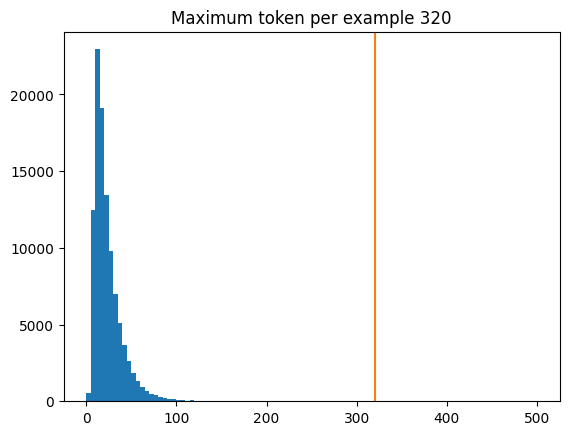

In [6]:
plt.hist(all_lengths, np.linspace(0, 500, 101))
plt.ylim(plt.ylim())
max_length = max(all_lengths)
plt.plot([max_length, max_length], plt.ylim())
plt.title(f'Maximum token per example {max_length}')

## The embedding and position encoding layer

/tf/2023/attention-is-all-you-need/model/positional_embedding.py:10: RuntimeWarning: divide by zero encountered in divide
  angle_rates = 1 / (10000 * depths)
/tf/2023/attention-is-all-you-need/model/positional_embedding.py:11: RuntimeWarning: invalid value encountered in multiply
  angle_rads = positions * angle_rates
/tf/2023/attention-is-all-you-need/model/positional_embedding.py:13: RuntimeWarning: invalid value encountered in sin
  pos_encoding = np.concatenate([np.sin(angle_rads), np.cos(angle_rads)],
/tf/2023/attention-is-all-you-need/model/positional_embedding.py:13: RuntimeWarning: invalid value encountered in cos
  pos_encoding = np.concatenate([np.sin(angle_rads), np.cos(angle_rads)],


(2048, 512)


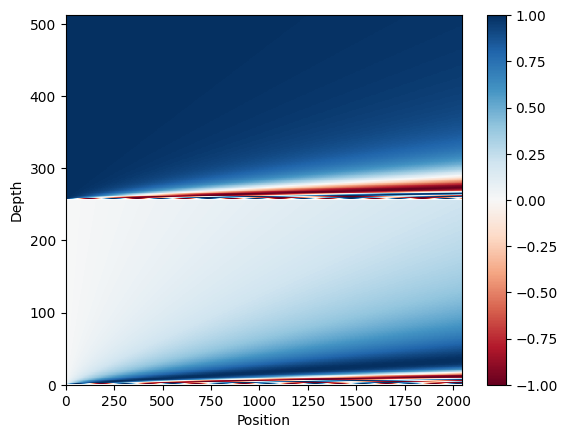

In [7]:
from model.positional_embedding import positional_encoding

pos_encoding = positional_encoding(length=2048, depth=512)
print(pos_encoding.shape)
plt.pcolormesh(pos_encoding.numpy().T, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

(0.0, 1.0)

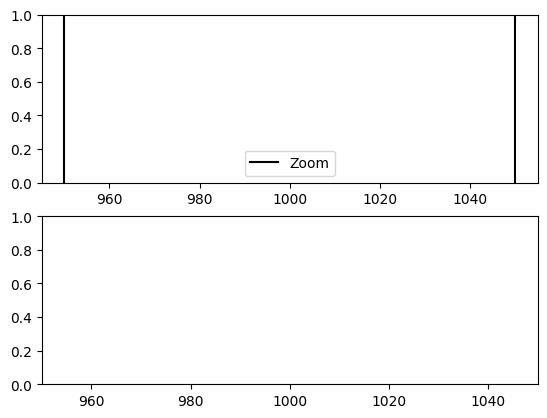

In [8]:
import tensorflow as tf

pos_encoding/= tf.norm(pos_encoding, axis=1, keepdims=True)
p = pos_encoding[1000]
dots = tf.einsum('pd,d -> p', pos_encoding, p)
plt.subplot(2,1,1)
plt.plot(dots)
plt.ylim([0,1])
plt.plot([950, 950, float('nan'), 1050, 1050],
        [0,1,float('nan'), 0, 1],
        color='k',
        label='Zoom')
plt.legend()
plt.subplot(2,1,2)
plt.plot(dots)
plt.xlim([950, 1050])
plt.ylim([0,1])

In [9]:
for (pt, en), en_labels in train_ted_ds.take(1):
    break

print(pt_tokenizer.detokenize(pt))
print(en_tokenizer.detokenize(en))
print(pt.shape)
print(en.shape)
print(en_labels.shape)

2023-06-24 10:18:40.846848: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [1]
	 [[{{node Placeholder/_3}}]]
2023-06-24 10:18:40.847276: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_31' with dtype string
	 [[{{node Placeholder/_31}}]]
2023-06-24 10:18:41.603589: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `d

tf.Tensor(
[b'e quem beneficia com isso ?'
 b'e o que parece ter acontecido aqui e que os comerciantes do indo , os mercadores , estavam a usar esta escrita para escrever uma lingua estrangeira .'
 b'e compreendo - as . quem e que as pode culpar ?'
 b'todo o material foi filmado com o nosso vor , que e um robo que construimos na nossa garagem .'
 b'ha pouco mais de uma decada , dois grupos de fisicos e astronomos lancaram - se na tentativa de medir o ritmo a que a expansao do espaco estava a abrandar .'
 b'ja nao sao pessoas mas simples linhas e eu vou trabalhar com eles quase como se fossem objectos , sim ?'
 b'e isso , claro , e aquilo com que todos somos atualmente ameacados devido as tatuagens eletronicas .'
 b'mas nao fui criado para pensar em mim , de forma alguma , como extraordinario .'
 b'mudaram - se para uma casa perto de um parque .'
 b'os meus alunos disseram que eu deveria pensar seriamente em obter alguma protecao .'
 b'as relacoes pessoais , penso eu , sao provavelmente

In [10]:
from model.positional_embedding import PositionalEmbedding

embed_pt = PositionalEmbedding(vocab_size=pt_tokenizer.get_vocab_size(), d_model=512)
embed_en = PositionalEmbedding(vocab_size=en_tokenizer.get_vocab_size(), d_model=512)

pt_embed = embed_pt(pt)
en_embed = embed_en(en)

pt_embed,en_embed

(<tf.Tensor: shape=(32, 40, 512), dtype=float32, numpy=
 array([[[        nan,  1.0735826 ,  0.36689818, ...,  1.8362036 ,
           0.41851485,  0.06802005],
         [        nan, -0.47567916,  0.6694212 , ...,  1.8468287 ,
          -0.03521132,  0.6418586 ],
         [        nan, -0.37970287, -0.4794752 , ...,  0.5603721 ,
           0.43453848,  1.8807633 ],
         ...,
         [        nan,  0.70043254,  1.0216144 , ...,  1.9151654 ,
           1.5719473 , -0.01861727],
         [        nan,  0.71511424,  1.0329678 , ...,  1.9151652 ,
           1.5719471 , -0.01861763],
         [        nan,  0.72925436,  1.0442448 , ...,  1.9151647 ,
           1.5719466 , -0.01861805]],
 
        [[        nan,  1.0735826 ,  0.36689818, ...,  1.8362036 ,
           0.41851485,  0.06802005],
         [        nan, -0.47567916,  0.6694212 , ...,  1.8468287 ,
          -0.03521132,  0.6418586 ],
         [        nan, -0.64086795, -0.15741639, ...,  1.2055067 ,
           0.9287485 ,  1.33

In [11]:
en_embed._keras_mask

<tf.Tensor: shape=(32, 36), dtype=bool, numpy=
array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])>

## Cross Attention

In [12]:
from model.attention import CrossAttention

sample_ca = CrossAttention(num_heads=2, key_dim=512)

print(pt_embed.shape)
print(en_embed.shape)
after_cross_attn = sample_ca(en_embed,pt_embed)
print(after_cross_attn.shape)

(32, 40, 512)
(32, 36, 512)


2023-06-24 10:18:42.508230: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


(32, 36, 512)


2023-06-24 10:18:42.736787: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600


## Global Attention

In [13]:
from model.attention import GlobalSelfAttention

global_self_attn = GlobalSelfAttention(num_heads=2,key_dim=512)

print(pt_embed.shape)
global_self_attn_output = global_self_attn(pt_embed)
print(global_self_attn_output.shape)

(32, 40, 512)
(32, 40, 512)


## Casual Attention

In [14]:
from model.attention import CasualSelfAttention

casual_attn = CasualSelfAttention(num_heads=2, key_dim=512)
print(en_embed.shape)
casual_attn_output = casual_attn(en_embed)
print(casual_attn_output.shape)

(32, 36, 512)
(32, 36, 512)


## Feed Forward

In [15]:
from model.feed_forward import FeedForward

sample_ffn = FeedForward(d_model=512,
                        dff=2048)

print(en_embed.shape)
sample_ffn_output = sample_ffn(en_embed)
print(sample_ffn_output.shape)

(32, 36, 512)
(32, 36, 512)


## Encoder Layer

In [16]:
from model.encoder import EncoderLayer

sample_encoder_layer = EncoderLayer(d_model=512, 
                                    num_heads=8, 
                                    dff=2048, 
                                    dropout_rate=0.1)
print(f'input is portugues language embedding of shape {pt_embed.shape}')
sample_encoder_layer_output = sample_encoder_layer(pt_embed)
print(f'output of encoder layer is of shape {sample_encoder_layer_output.shape}')

input is portugues language embedding of shape (32, 40, 512)
output of encoder layer is of shape (32, 40, 512)


## Encoder Block

In [ ]:
from model.encoder import EncoderBlock

sample_encoder = EncoderBlock(num_layers=4, 
                              d_model=512, 
                              num_heads=8, 
                              dff=2048, 
                              vocab_size=8500, 
                              dropout_rate=0.1)
sample_encoder_output = sample_encoder(pt, training=False)
print(f'input to encoder block is portugues batch of shape {pt.shape}')
print(f'output of encoder block is {sample_encoder_output.shape}')

## Decoder Layer

In [ ]:
from model.decoder import DecoderLayer

sample_decoder_layer = DecoderLayer(d_model=512, 
                                    num_heads=8, 
                                    dff=2048, 
                                    dropout_rate=0.1)
sample_decoder_layer_output = sample_decoder_layer(x=en_embed,
                                                   context=pt_embed)
print(f'input shape of english embedding {en_embed.shape}')
print(f'context shape of portugues embedding {pt_embed.shape}')
print(f'output shape of decoder layer {sample_decoder_layer_output.shape}')

## Decoder Block

In [ ]:
from model.decoder import DecoderBlock

sample_decoder = DecoderBlock(num_layers=4, 
                              d_model=512, 
                              num_heads=8, 
                              dff=2048, 
                              vocab_size=8000, 
                              dropout_rate=0.1)
sample_decoder_output = sample_decoder(x=en,
                                      context=pt_embed)
print(f'input shape of english shape {en.shape}')
print(f'context shape of portugues embedding {pt_embed.shape}')
print(f'output shape of decoder layer {sample_decoder_output.shape}')

In [ ]:
sample_decoder.last_attn_scores.shape

## Transformer

In [ ]:
from model.transformer import Transformer

transformer = Transformer(num_layers=4, 
                          d_model=512, 
                          num_heads=8, 
                          dff=2048, 
                          src_vocab_size=pt_tokenizer.get_vocab_size(), 
                          target_vocab_size=en_tokenizer.get_vocab_size(), 
                          dropout_rate=0.1)
transformer_output = transformer((pt,en))
print(f'input shape of english shape {en.shape}')
print(f'context shape of portugues  {pt.shape}')
print(f'output shape of transformer {transformer_output.shape}')

In [ ]:
attn_scores = transformer.decoder.decoder_layer[-1].last_attn_scores
print(attn_scores.shape)

In [ ]:
transformer.summary()

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(transformer, show_shapes=True)

## Training

In [19]:
from train import TransformerTraining

training = TransformerTraining()
training.compile()

In [17]:
train_ted_ds.take(1)

<_TakeDataset element_spec=((TensorSpec(shape=(None, None), dtype=tf.int64, name=None), TensorSpec(shape=(None, None), dtype=tf.int64, name=None)), TensorSpec(shape=(None, None), dtype=tf.int64, name=None))>

In [20]:
training.fit(train_ted_ds, val_ted_ds)

2023-06-24 10:22:39.422931: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_34' with dtype resource
	 [[{{node Placeholder/_34}}]]
2023-06-24 10:22:39.423339: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_33' with dtype string
	 [[{{node Placeholder/_33}}]]


Epoch 1/3


2023-06-24 10:23:00.241338: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 27.50MiB (rounded to 28835840)requested by op transformer/decoder_block/decoder_layer_2/casual_self_attention_3/multi_head_attention_12/query/einsum/Einsum
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-06-24 10:23:00.241436: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-06-24 10:23:00.241452: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 360, Chunks in use: 360. 90.0KiB allocated for chunks. 90.0KiB in use in bin. 903B client-requested in use in bin.
2023-06-24 10:23:00.241460: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B cl

2023-06-24 10:23:10.246375: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 27.50MiB (rounded to 28835840)requested by op transformer/decoder_block/decoder_layer_2/casual_self_attention_3/multi_head_attention_12/value/einsum/Einsum
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-06-24 10:23:10.246514: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-06-24 10:23:10.246531: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 360, Chunks in use: 360. 90.0KiB allocated for chunks. 90.0KiB in use in bin. 903B client-requested in use in bin.
2023-06-24 10:23:10.246540: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B cl

ResourceExhaustedError: Graph execution error:

Detected at node 'transformer/decoder_block/decoder_layer_2/casual_self_attention_3/multi_head_attention_12/query/einsum/Einsum' defined at (most recent call last):
    File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/usr/local/lib/python3.8/dist-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelapp.py", line 725, in start
      self.io_loop.start()
    File "/usr/local/lib/python3.8/dist-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell
      await result
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_4567/1555153759.py", line 1, in <module>
      training.fit(train_ted_ds, val_ted_ds)
    File "/tf/2023/attention-is-all-you-need/train.py", line 66, in fit
      self.training_history = self.transformer.fit(train_batches,
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1050, in train_step
      y_pred = self(x, training=True)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/tf/2023/attention-is-all-you-need/model/transformer.py", line 27, in call
      x = self.decoder(x, context)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/tf/2023/attention-is-all-you-need/model/decoder.py", line 52, in call
      for i in range(self.num_layers):
    File "/tf/2023/attention-is-all-you-need/model/decoder.py", line 53, in call
      x = self.decoder_layer[i](x, context)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/tf/2023/attention-is-all-you-need/model/decoder.py", line 21, in call
      x = self.casual_self_attn(x=x)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/tf/2023/attention-is-all-you-need/model/attention.py", line 42, in call
      attn_output = self.multi_head_attention(query=x,
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/layers/attention/multi_head_attention.py", line 590, in call
      query = self._query_dense(query)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/layers/core/einsum_dense.py", line 207, in call
      ret = tf.einsum(self.equation, inputs, self.kernel)
Node: 'transformer/decoder_block/decoder_layer_2/casual_self_attention_3/multi_head_attention_12/query/einsum/Einsum'
OOM when allocating tensor with shape[1760,4096] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node transformer/decoder_block/decoder_layer_2/casual_self_attention_3/multi_head_attention_12/query/einsum/Einsum}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_32402]